# Kr analysis (run 4103)

# Notebook configuration

In [1]:
outputfolder  = "plots/"
save_plots    = False
inputfilename = "/Users/Gonzalo/github/NEXTdata/Bkg/dst_4103.root.h5"

In [2]:
import os
import functools
import textwrap
import time
import glob
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf

pi = np.pi

coref = fitf

Running on  Fri May 26 20:45:31 2017


#### General plotting options

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
XR1Opt  = "k"
XR2Opt  = "c"
KrOpt   = "m"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [4]:
def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, xrange, yrange, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, xrange, yrange, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.hist2d(x_, y_, nbin, (xrange, yrange), weights=z_), plt.colorbar()


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()

def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values, ene=29.6):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (ene/2458)**0.5

def gausstext(values, ene=29.6):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values, ene)))

def save_to_folder(save_plots, outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    if save_plots:
        plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

save = functools.partial(save_to_folder, save_plots, outputfolder)

### Input data

In [5]:
ifile = os.path.expandvars(inputfilename)
print("ifile:", ifile)

ifile: /Users/Gonzalo/github/NEXTdata/Bkg/dst_4103.root.h5


# Read data

In [6]:
full = dstf.load_dst(ifile, "DST", "Events")
full = full[full.R<200]
print(len(full))
full.head()

62697


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,9,1.495706e+09,0,1,325.0,11.631553,58.603669,1046400.0,23.232875,3995.072754,...,1505462.5,9,459.0625,459.0625,41.734950,-12.171147,43.473473,-0.283760,8.062350,7.085191
1,10,1.495706e+09,0,1,350.0,6.719637,38.901876,1041225.0,28.021500,2651.914551,...,1509462.5,10,468.2375,468.2375,102.305469,-41.175158,110.280563,-0.382636,29.481533,5.941804
2,13,1.495706e+09,0,2,275.0,4.120865,26.184799,1129850.0,18.080000,2173.759033,...,1504462.5,1,374.6125,374.6125,-25.000000,165.000000,166.883193,1.721168,0.000000,0.000000
3,13,1.495706e+09,1,2,275.0,4.120865,26.184799,1129850.0,10.694375,785.513916,...,1549862.5,2,420.0125,420.0125,35.000000,160.121929,163.902508,1.355598,0.000000,5.065879
4,15,1.495706e+09,0,1,225.0,6.484250,41.684451,1089175.0,23.221875,2664.236816,...,1505462.5,14,416.2875,416.2875,-128.363862,-35.200255,133.102739,-2.873949,9.820269,9.785881


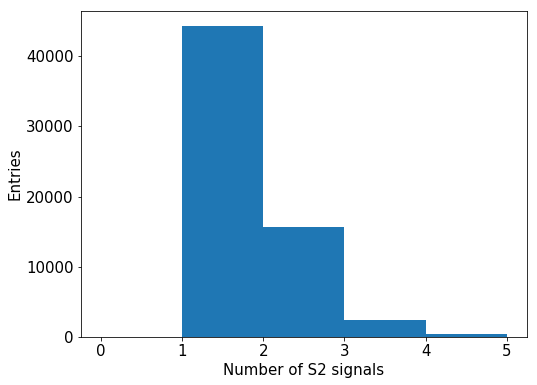

In [7]:
hist(full.nS2, 5, (0,5))
labels("Number of S2 signals", "Entries")

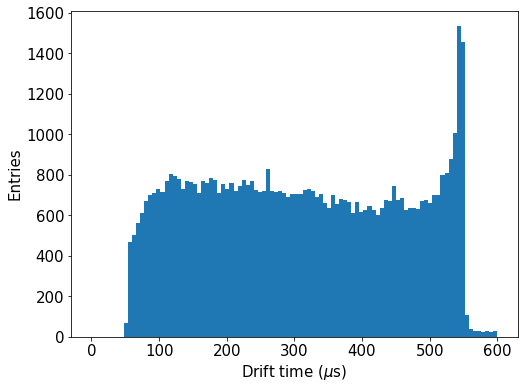

In [8]:
hist(full.Z, 100, (0,600))
labels("Drift time ($\mu$s)", "Entries")

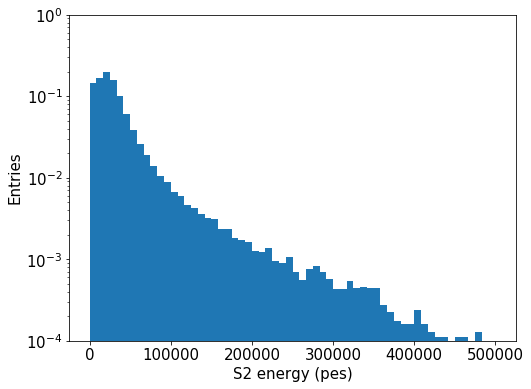

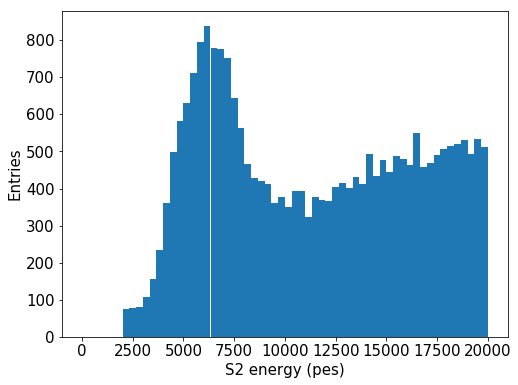

In [9]:
pdf(full.S2e, 60, (0,500e3))
labels("S2 energy (pes)", "Entries")

hist(full.S2e, 60, (0,20e3))
labels("S2 energy (pes)", "Entries")

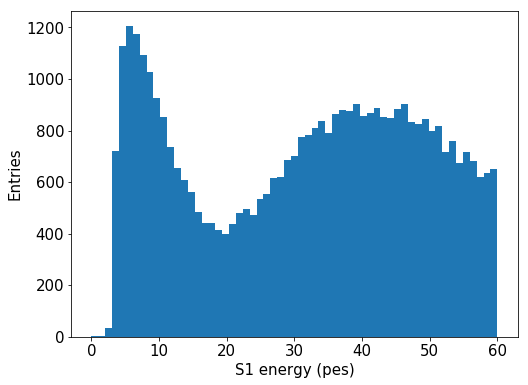

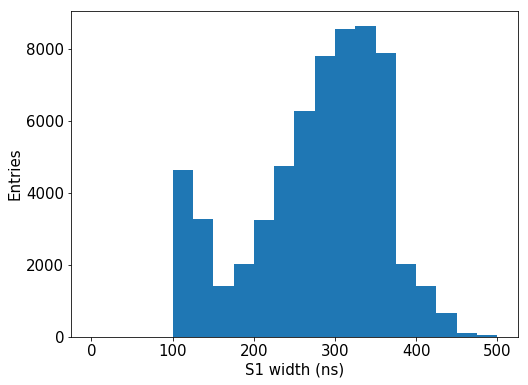

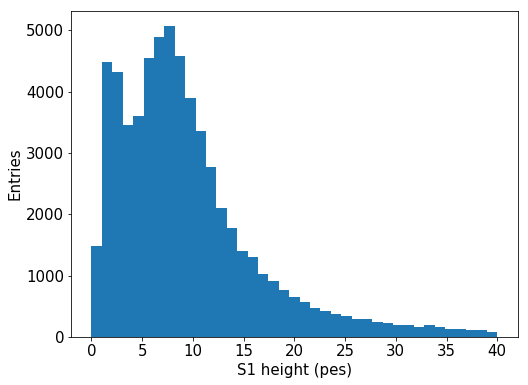

In [10]:
bins = np.linspace(0, 60, 60)
hist(full.S1e, bins)
labels("S1 energy (pes)", "Entries")

bins = np.linspace(0, 500, 21)
hist(full.S1w, bins)
labels("S1 width (ns)", "Entries")

bins = np.linspace(0, 40, 40)
hist(full.S1h, bins)
labels("S1 height (pes)", "Entries")

# S2 energy vs Z

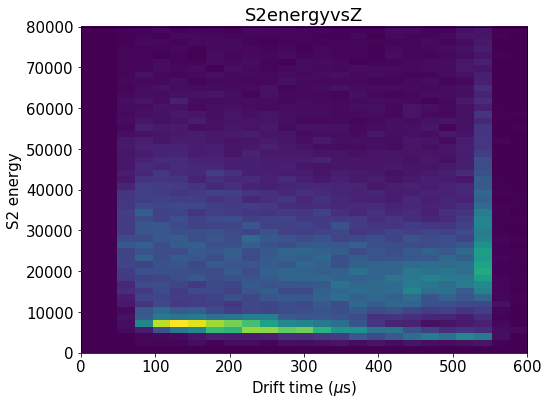

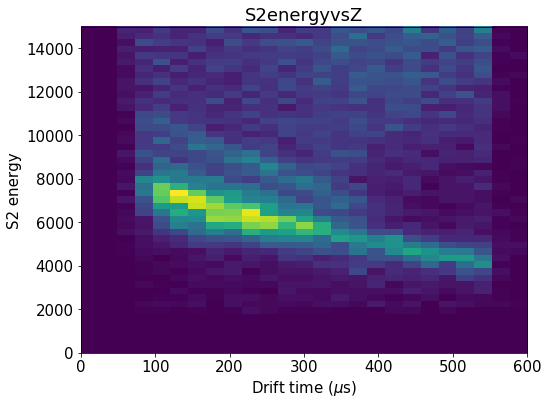

In [11]:
zrange = 0, 600
Erange = 0, 80e3
hist2d(full.Z, full.S2e, (25,  50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ")

Erange = 0, 15e3
hist2d(full.Z, full.S2e, (25,  50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ")

# S1 energy

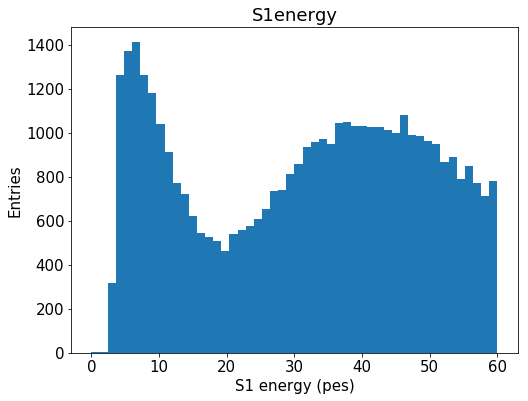

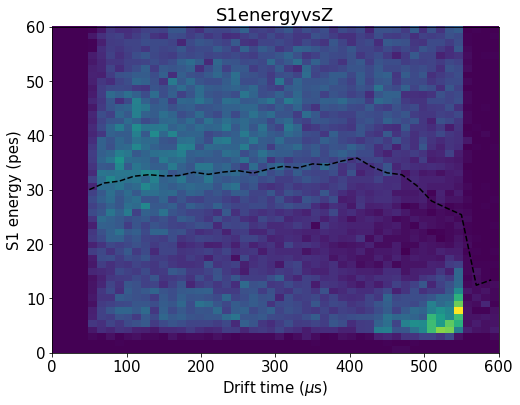

In [12]:
zrange = 0, 600
Srange = 0, 60

hist(full.S1e, 50, range=Srange)
labels("S1 energy (pes)", "Entries")
save("S1energy")

hist2d(full.Z, full.S1e, (50, 50), range=(zrange, Srange))
x, y, _ = fitf.profileX(full.Z, full.S1e, 30, xrange=zrange, yrange=Srange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1energyvsZ")

# S1 width

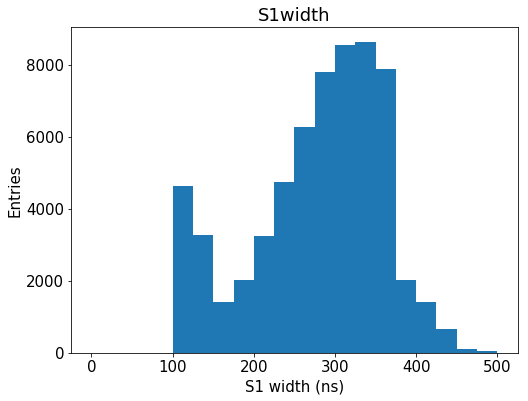

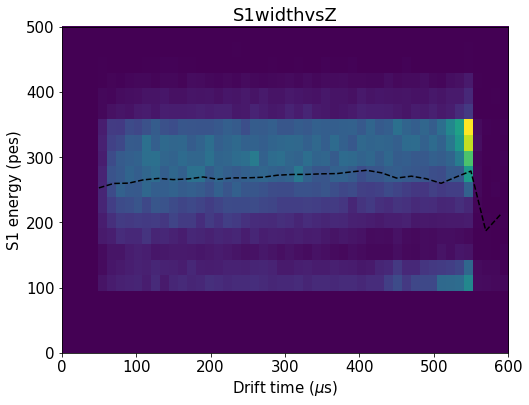

In [13]:
zrange = 0, 600
wrange = 0, 500

hist(full.S1w, np.linspace(*wrange, 21))
labels("S1 width (ns)", "Entries")
save("S1width")

hist2d(full.Z, full.S1w, (50, 21), range=(zrange, wrange))
x, y, _ = fitf.profileX(full.Z, full.S1w, 30, xrange=zrange, yrange=wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1widthvsZ")

# S1 height

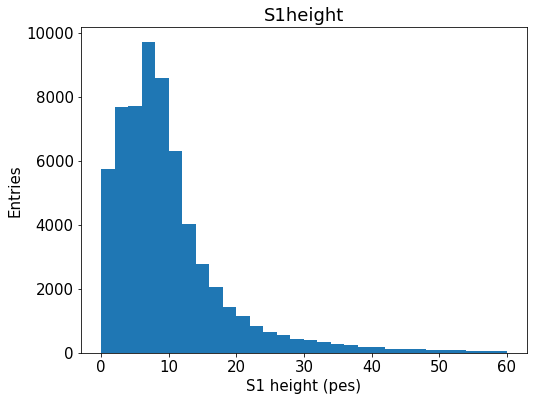

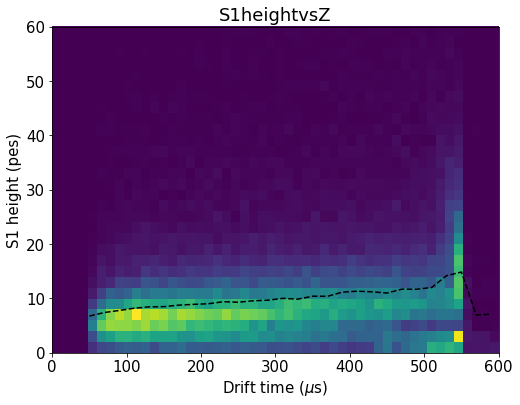

In [14]:
zrange = 0, 600
hrange = 0, 60

hist(full.S1h, 30, range=hrange)
labels("S1 height (pes)", "Entries")
save("S1height")

hist2d(full.Z, full.S1h, (50, 30), range=(zrange, hrange))
x, y, _ = fitf.profileX(full.Z, full.S1h, 30, xrange=zrange, yrange=hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 height (pes)")
save("S1heightvsZ")

# S1 peak to area ratio

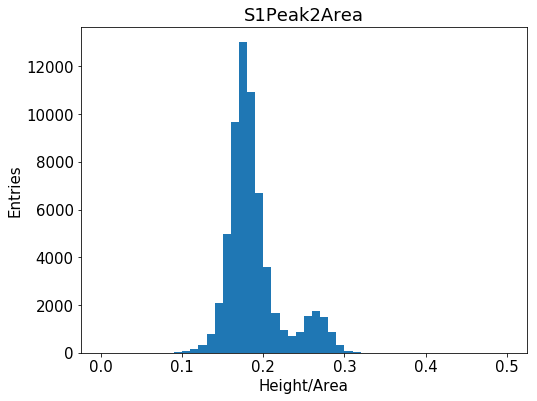

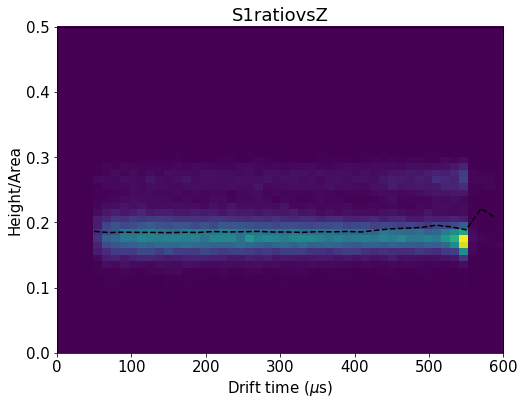

In [15]:
zrange = 0, 600
rrange = 0, 0.5

S1r = full.S1h/full.S1e
hist(S1r, 50, range=rrange)
labels("Height/Area", "Entries")
save("S1Peak2Area")

hist2d(full.Z, S1r, (50, 50), range=(zrange, rrange))
x, y, _ = fitf.profileX(full.Z, S1r, 30, xrange=zrange, yrange=rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area")
save("S1ratiovsZ")

# S2 energy

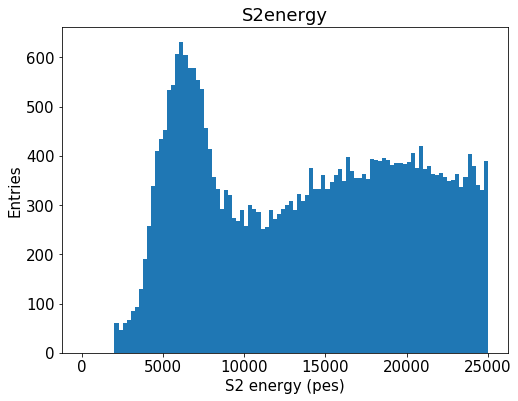

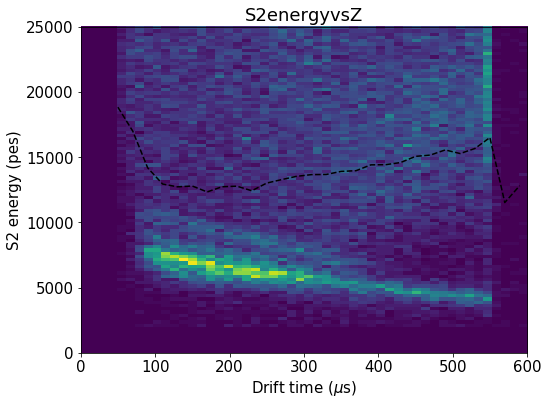

In [16]:
zrange = 0, 600
Erange = 0, 25e3

hist(full.S2e, 100, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy")

hist2d(full.Z, full.S2e, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(full.Z, full.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

# S2 width

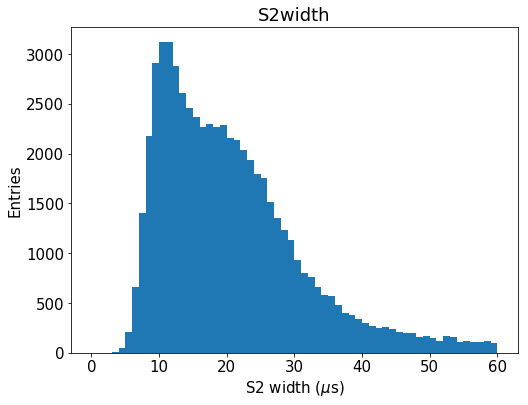

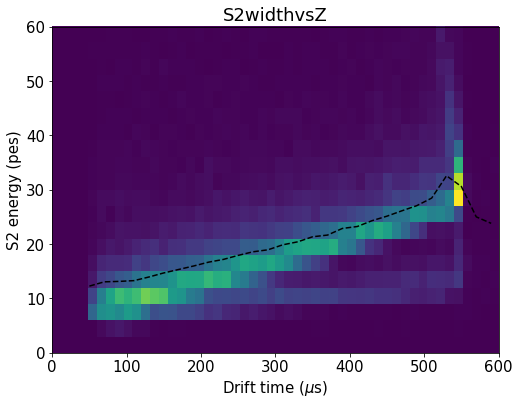

In [17]:
zrange = 0, 600
wrange = 0, 60

hist(full.S2w, 60, range=wrange)
labels("S2 width ($\mu$s)", "Entries")
save("S2width")

hist2d(full.Z, full.S2w, (50, 20), range=(zrange, wrange))
x, y, _ = fitf.profileX(full.Z, full.S2w, 30, xrange=zrange, yrange=wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2widthvsZ")

# S2 height

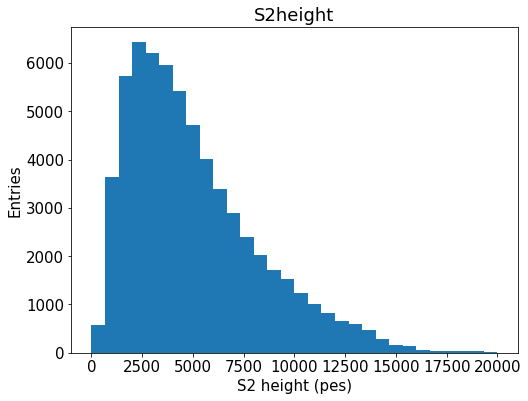

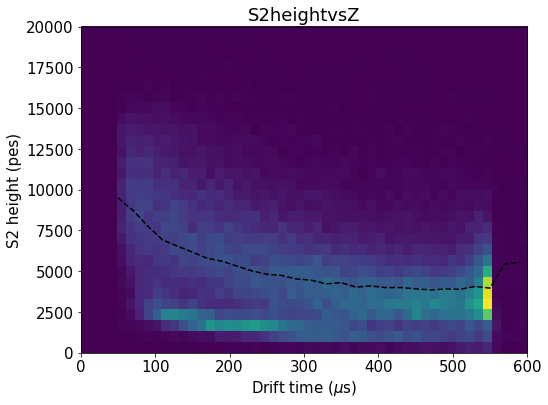

In [18]:
zrange = 0, 600
hrange = 0, 20e3

hist(full.S2h, 30, range=hrange)
labels("S2 height (pes)", "Entries")
save("S2height")

hist2d(full.Z, full.S2h, (50, 30), range=(zrange, hrange))
x, y, _ = fitf.profileX(full.Z, full.S2h, 30, xrange=zrange, yrange=hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

# S2 peak to area ratio

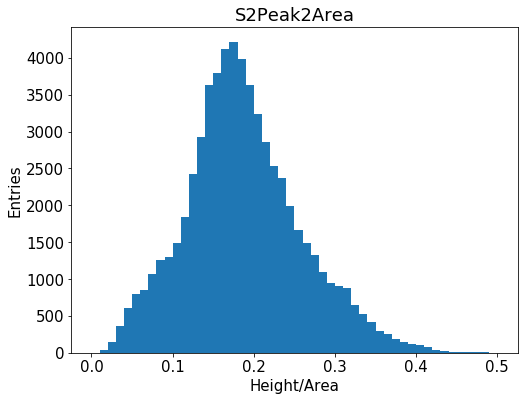

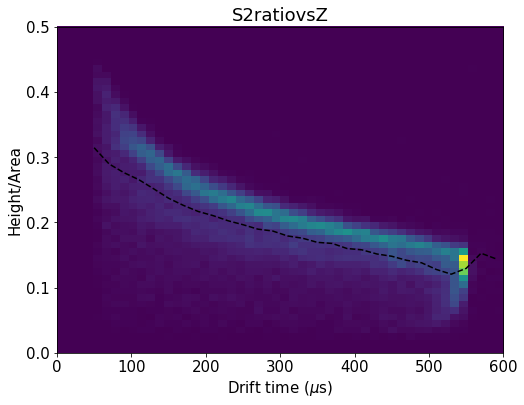

In [19]:
zrange = 0, 600
rrange = 0, 0.5

S2r = full.S2h/full.S2e

hist(S2r, 50, range=rrange)
labels("Height/Area", "Entries")
save("S2Peak2Area")

hist2d(full.Z, S2r, (50, 50), range=(zrange, rrange))
x, y, _ = fitf.profileX(full.Z, S2r, 30, xrange=zrange, yrange=rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area")
save("S2ratiovsZ")

# S2 vs S1

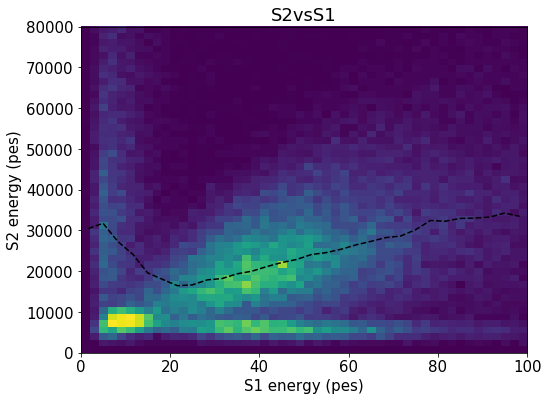

In [20]:
Srange = 0, 100
Erange = 0, 80e3

S = full.S1e
E = full.S2e

hist2d(S, E, (50, 50), range=(Srange, Erange))
x, y, _ = fitf.profileX(S, E, 30, xrange=Srange, yrange=Erange)
plt.plot(x, y, profOpt)

sel = fitf.in_range(S, *Srange) & coref.in_range(E, *Erange)
#c = covariance(S[sel], E[sel])
#print(*c)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

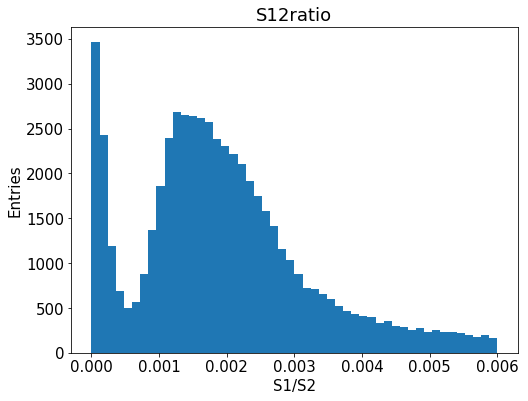

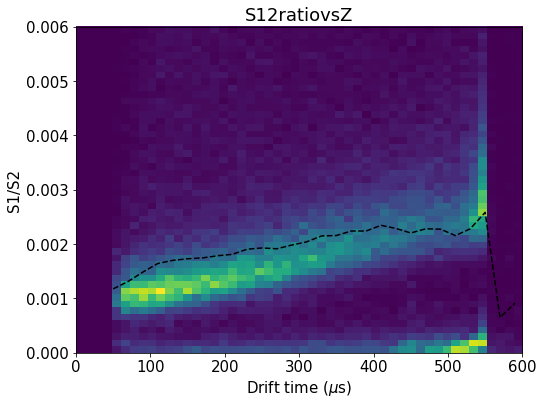

In [21]:
zrange = 0, 600
Rrange = 0, 0.006

S12r = full.S1e/full.S2e

hist(S12r, 50, range=Rrange)
labels("S1/S2", "Entries")
save("S12ratio")

hist2d(full.Z, S12r, (50, 50), range=(zrange, Rrange))
x, y, _ = fitf.profileX(full.Z, S12r, 30, xrange=zrange, yrange=Rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2")
save("S12ratiovsZ")

# Temporary fiducialization

In [22]:
fid = full
fid = fid[fid.R < 100]
print("Ratio:", len(fid)/len(full))
fid.head()

Ratio: 0.24187760179912915


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,9,1.495706e+09,0,1,325.0,11.631553,58.603669,1046400.0,23.232875,3995.072754,...,1505462.5,9,459.0625,459.0625,41.734950,-12.171147,43.473473,-0.283760,8.062350,7.085191
5,23,1.495706e+09,0,1,325.0,22.098110,115.356879,1278875.0,26.978250,12273.464844,...,1505462.5,37,226.5875,226.5875,-79.593192,41.412228,89.722064,2.661838,10.481949,11.658721
7,25,1.495706e+09,0,1,300.0,12.379839,69.792456,1166850.0,23.125250,7890.268066,...,1505462.5,24,338.6125,338.6125,-45.715824,42.860749,62.665624,2.388416,10.158657,10.674388
10,29,1.495706e+09,0,1,325.0,13.824805,75.179629,1359850.0,19.555000,12438.158203,...,1505462.5,35,145.6125,145.6125,14.812331,-56.570528,58.477601,-1.314707,10.709331,10.297336
11,35,1.495706e+09,0,1,325.0,6.304748,37.709725,1161275.0,21.339000,4563.545898,...,1506462.5,16,345.1875,345.1875,-4.071145,-17.869389,18.327283,-1.794801,9.173269,9.085143


# S2 energy fiducialized

[ 8802.44527592  -836.72300774]


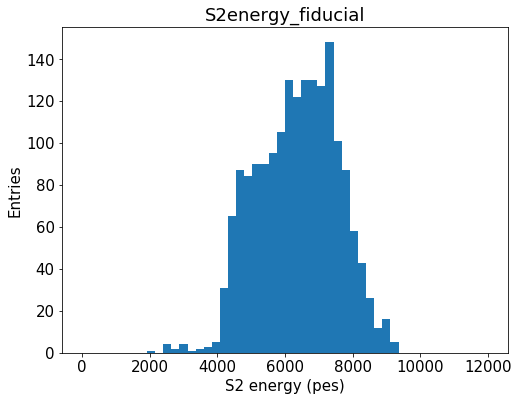

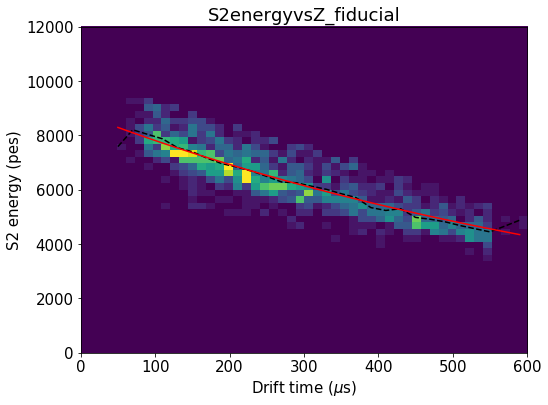

In [23]:
zrange = 0, 600
Erange = 0, 12e3

lowEfid = fid[coref.in_range(fid.S2e, 6e3 - 5*fid.Z.values, 10e3 - 8*fid.Z.values)]

hist(lowEfid.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy_fiducial")

hist2d(lowEfid.Z, lowEfid.S2e, (50, 50), range=(zrange, Erange))
x, y, _ = fitf.profileX(lowEfid.Z, lowEfid.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

f = fitf.fit(fitf.expo, x, y, (1e4, -600), fit_range=(100, 600))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ_fiducial")

zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

# Correction by attachment

[  1.63250529e+05   8.04764915e+03   4.27911560e+02   2.87112765e+04
   9.24125977e+03   2.87355845e+02   4.75371775e+04   1.10119248e+04
   6.10927082e+02   6.01487962e-01   7.88611373e-04]


/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:148: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  x, y = xdata[selection], ydata[selection]
/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:152: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  maxval = x_out[i+1])]
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[  4.02919948e+04  -2.52561429e+11]


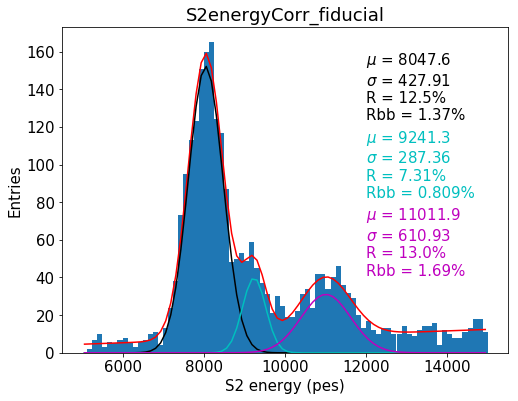

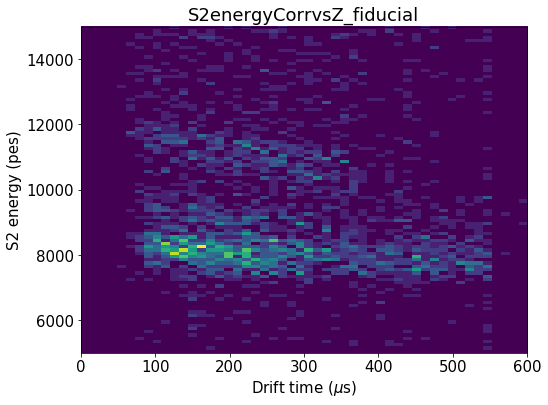

In [24]:
zrange = 0, 600
Erange = 5000, 15e3

E = fid.S2e.values * zcorr(fid.Z.values)

y, x, _ = hist(E, 80, range=Erange)

x    = x[:-1] + np.diff(x) * 0.5
fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.gauss  (x, *args[6:9]) + \
                        fitf.polynom(x, *args[9: ])
seed = 1e3, 8000, 100, 1e3,  9500, 100, 1e3, 12000, 400,  0, 0.001
low  =  10, 7000,  50,  10,  9000,  50,  10, 10500, 100, -1, 0
upp  = 1e8, 9900, 900, 1e7, 10000, 900, 5e6, 13000, 700,  1, 0.01
f    = fitf.fit(fun, x, y, seed, fit_range=(5000, 15000), bounds=(low, upp))
print(f.values)


plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[ :3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:6]), XR2Opt)
plt.plot(x, fitf.gauss(x, *f.values[6:9]),  KrOpt)
plt.text(Erange[1]*0.8, 3*max(y)/4, gausstext(f.values[ :3], 29.6), color=XR1Opt)
plt.text(Erange[1]*0.8, 2*max(y)/4, gausstext(f.values[3:6], 30.1), color=XR2Opt)
plt.text(Erange[1]*0.8, 1*max(y)/4, gausstext(f.values[6:9], 41.5), color=KrOpt)


labels("S2 energy (pes)", "Entries")
save("S2energyCorr_fiducial")

hist2d(fid.Z, E, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(fid.Z, E, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)

print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyCorrvsZ_fiducial")

# Tracking

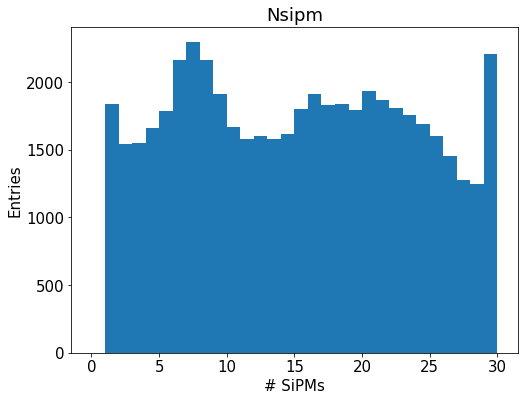

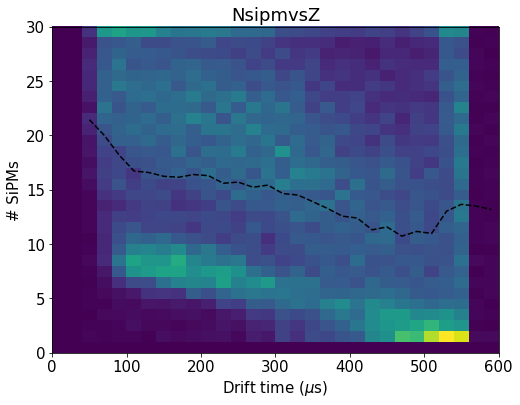

In [25]:
nrange = 0, 30
zrange = 0, 600

hist(full.Nsipm, max(nrange), nrange)
labels("# SiPMs", "Entries")
save("Nsipm")

hist2d(full.Z, full.Nsipm, (30, max(nrange)), range=(zrange, nrange))
x, y, _ = fitf.profileX(full.Z, full.Nsipm, 30, xrange=zrange, yrange=nrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs")
save("NsipmvsZ")


# XR distribution

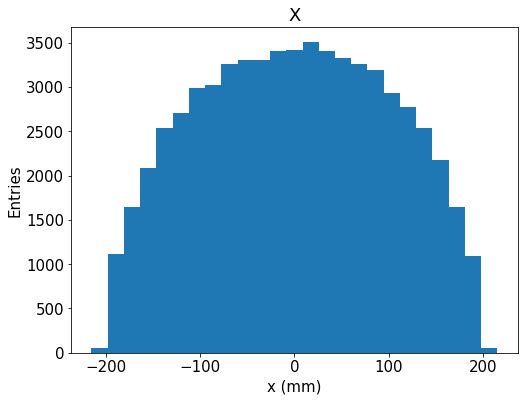

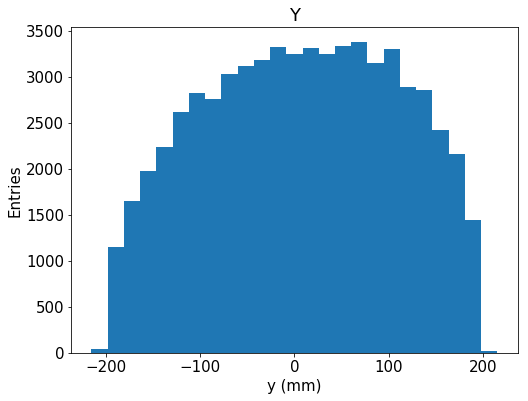

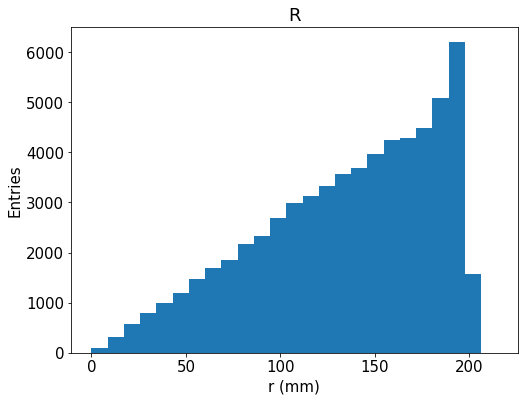

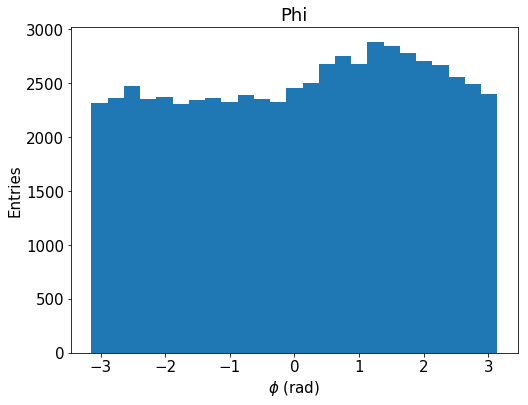

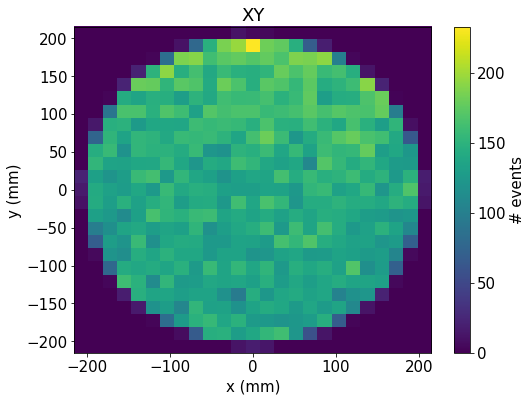

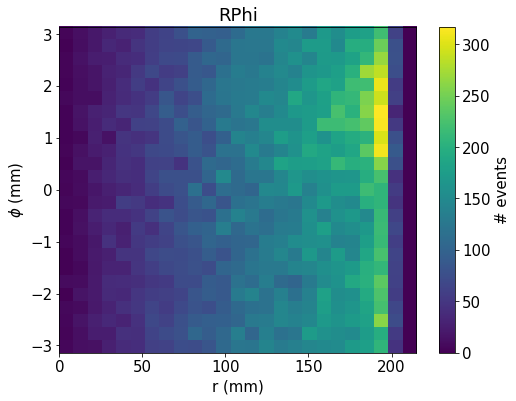

In [26]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(full.X, 25, range=xrange)
labels("x (mm)", "Entries")
save("X")

hist(full.Y, 25, range=yrange)
labels("y (mm)", "Entries")
save("Y")

hist(full.R, 25, range=rrange)
labels("r (mm)", "Entries")
save("R")

hist(full.Phi, 25, range=prange)
labels("$\phi$ (rad)", "Entries")
save("Phi")

nevts, xs, ys, _ = \
hist2d(full.X, full.Y, (25, 25), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")
save("XY")

hist2d(full.R, full.Phi, (25, 25), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

# Tracking charge

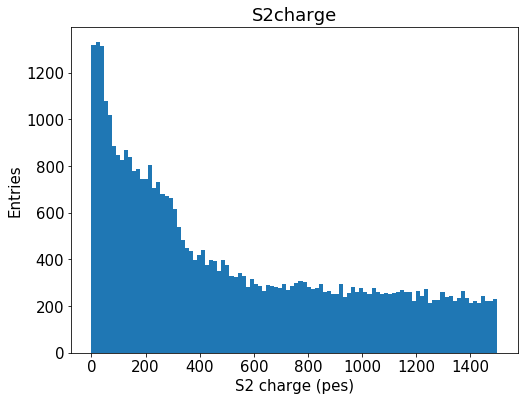

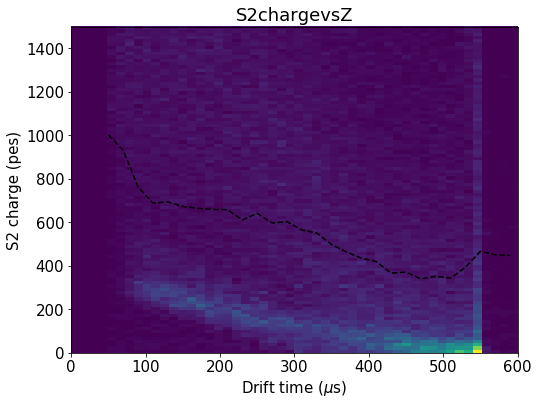

In [27]:
zrange = 0,  600
Qrange = 0, 1500

hist(full.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries")
save("S2charge")

hist2d(full.Z, full.S2q, (50, 100), range=(zrange, Qrange))
x, y, _ = fitf.profileX(full.Z, full.S2q, 30, xrange=zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)")
save("S2chargevsZ")

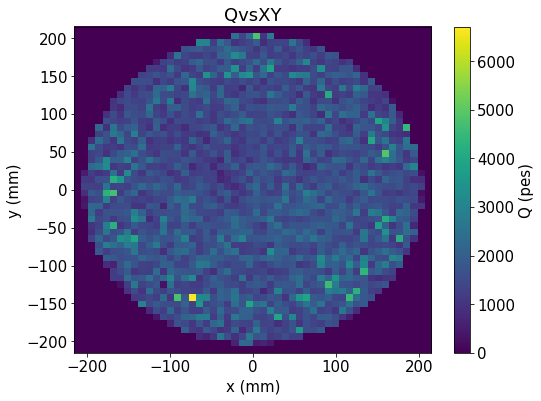

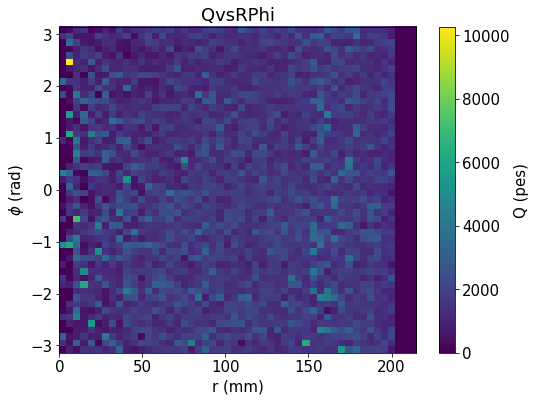

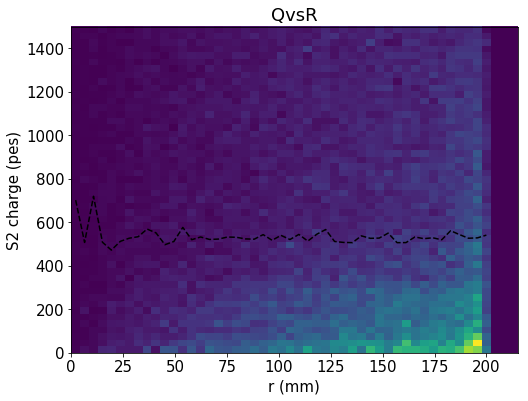

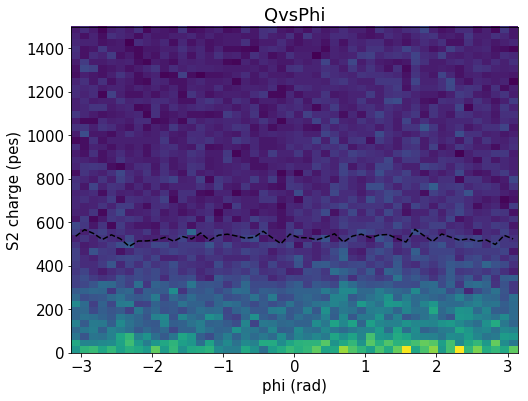

In [28]:
xrange = -215,  215
yrange = -215,  215
rrange =    0,  215
prange = - pi,   pi
Qrange =    0, 1500

_, _, cb = profile_and_scatter(full.X, full.Y, full.S2q, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

_, _, cb = profile_and_scatter(full.R, full.Phi, full.S2q, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

hist2d(full.R, full.S2q, (50, 50), range=(rrange, Qrange))
x, y, _ = fitf.profileX(full.R, full.S2q, 50, xrange=rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

hist2d(full.Phi, full.S2q, (50, 50), range=(prange, Qrange))
x, y, _ = fitf.profileX(full.Phi, full.S2q, 50, xrange=prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)")
save("QvsPhi")


# Energy vs position

7540.35043444


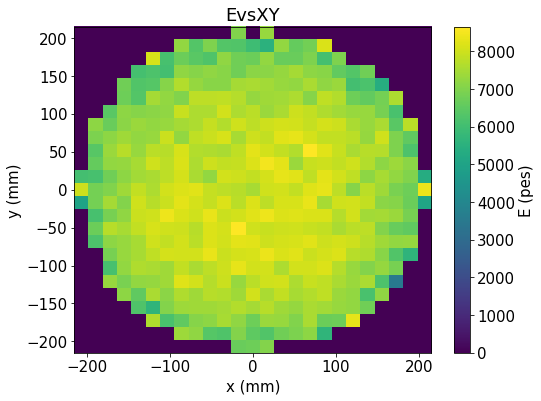

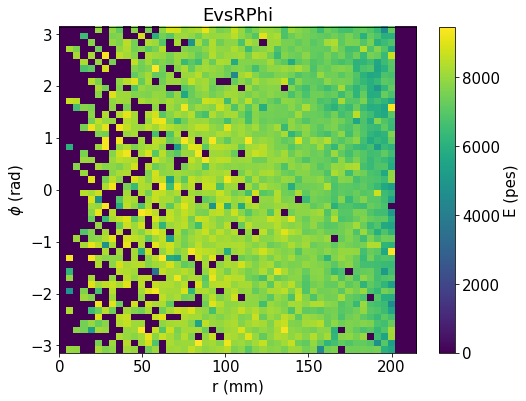

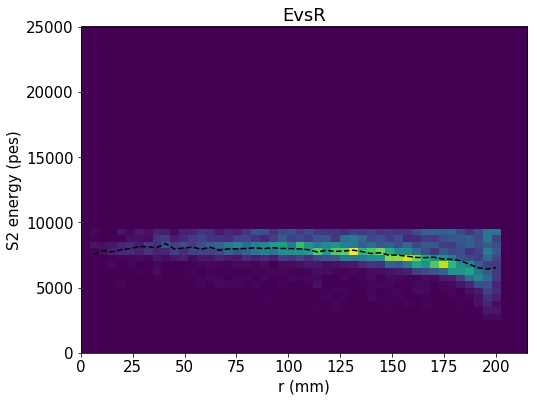

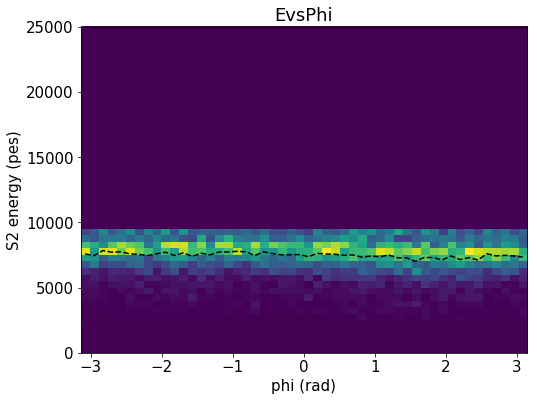

In [29]:
xrange = -215,  215
yrange = -215,  215
rrange =    0,  215
prange = - pi,   pi
Erange =    0, 25e3

E   = full.S2e * zcorr(full.Z)
sel = coref.in_range(E, 0, 9500)
XR  = full[sel]
E   = E   [sel]

pf, _, cb = profile_and_scatter(XR.X, XR.Y, E, (25, 25), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(XR.R, XR.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])


# Correction by attachment and position

[  5.37408501e+05   7.43114721e+03   4.68281661e+02   7.74444141e+04
   8.55810151e+03   3.19939352e+02   1.38622153e+05   1.01037255e+04
   6.65146381e+02   1.00000000e+00   5.01402932e-03]


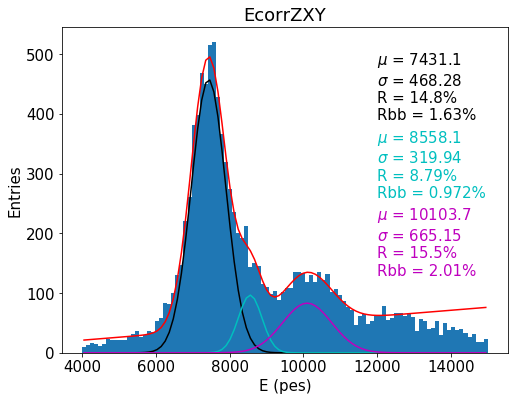

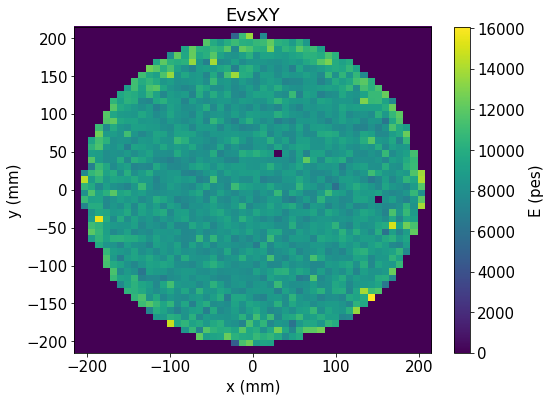

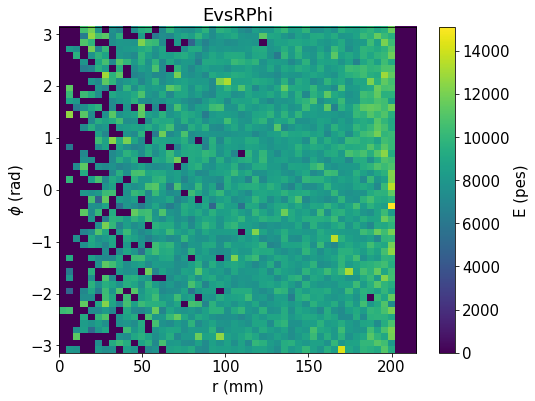

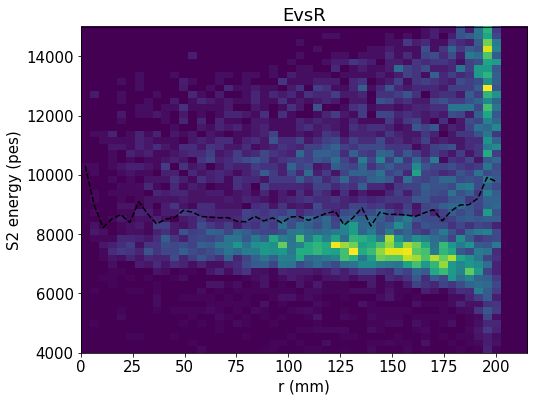

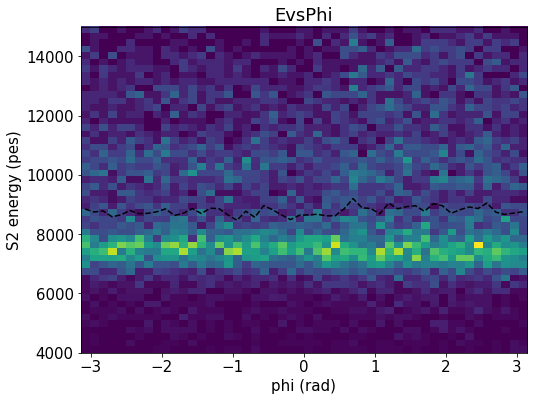

In [30]:
xrange = -215,  215
yrange = -215,  215
rrange =    0,  215
prange = - pi,   pi
Erange =  4e3, 15e3

sel = coref.in_range(full.S2e * zcorr(full.Z), 0, 14e3)
XR  = full[sel]

E  = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)
XR = full[sel]
E  = E   [sel]

y, x, _ = hist(E, 100, Erange)
x    = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.gauss  (x, *args[6:9]) + \
                        fitf.polynom(x, *args[9: ])
seed = 1e3, 7500, 100, 1e3,  8000, 100, 1e3, 10000, 400,  0, 0.001
low  =  10, 7000,  50,  10,  7900,  50,  10,  9500, 100, -1, 0
upp  = 1e8, 8000, 900, 1e7,  8600, 900, 5e6, 10500, 700,  1, 0.01
f    = fitf.fit(fun, x, y, seed, fit_range=(5000, 12000), bounds=(low, upp))
print(f.values)


plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[ :3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:6]), XR2Opt)
plt.plot(x, fitf.gauss(x, *f.values[6:9]),  KrOpt)
plt.text(Erange[1]*0.8, 3*max(y)/4, gausstext(f.values[ :3], 29.6), color=XR1Opt)
plt.text(Erange[1]*0.8, 2*max(y)/4, gausstext(f.values[3:6], 30.1), color=XR2Opt)
plt.text(Erange[1]*0.8, 1*max(y)/4, gausstext(f.values[6:9], 41.5), color=KrOpt)

labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(XR.R, XR.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")
